# < 3주차 과제 1 : MLP 마음대로 다뤄보기>
- dataset을 임의로 선정해서 직접 분석 해보기(제공한 코드를 활용해서 해보기)
- activation functions 중 relu사용시 함수 직접 정의
- lr, optimizer 등 바꿔보기
- hidden layer/neuron 수를 바꾸기
- 전처리도 추가
- 모든 시도를 올려주세요!
- 제일 높은 acc를 보인 시도를 명시해주세요!


In [6]:
import torch
from torch import nn, optim
from sklearn.datasets import load_breast_cancer
from torch.utils.data import  TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# torch.nn: 신경망을 구축하기 위한 다양한 데이터 구조나 레이어 등이 정의
# torch.optim: 확률적 경사 하강법(Stochastic Gradient Descent, SGD)를 중심으로 한 파라미터 최적화 알고리즘이 구현
# torch.utils.data: SGD의 반복 연산을 실행할 때 사용하는 미니 배치용 유틸리티 함수가 포함
# sklearn.model.data: 교차 검증을 위한 학습용/테스트용 데이터 분리, 그리드 서치로 최적 파라미터 추출 등의 API 제공
# sklearn.metrics: 분류, 회귀, 클러스터링에 대한 다양한 성능 측정 방법 제공(Accuracy, Precision, ROC-AUC RMSE 등)
# sklearn.preprocessing: 데이터 전처리에 필요한 다양한 가공 기능 제공

## 아래 데이터셋 중 원하는 데이터셋 하나를 선택하여, 코드 과제 진행하기!
- 1) load_digits() <br>
- 2) load_wine()

1. 활성함수 바꾸기
2. lr 바꾸기
3. optimizer 바꾸기
4. momentum 바꿔보기
5. => 위의 시도 기록

# 1.1 Load_wine
### activation function: ```sigmoid ```
### Optimizer: ```adam```,
### lr: 0.01

model의 output은 :  [0.99148977 0.00349057 0.00501973]
argmax를 한 후의 output은 0
accuracy는 0.8333333333333334

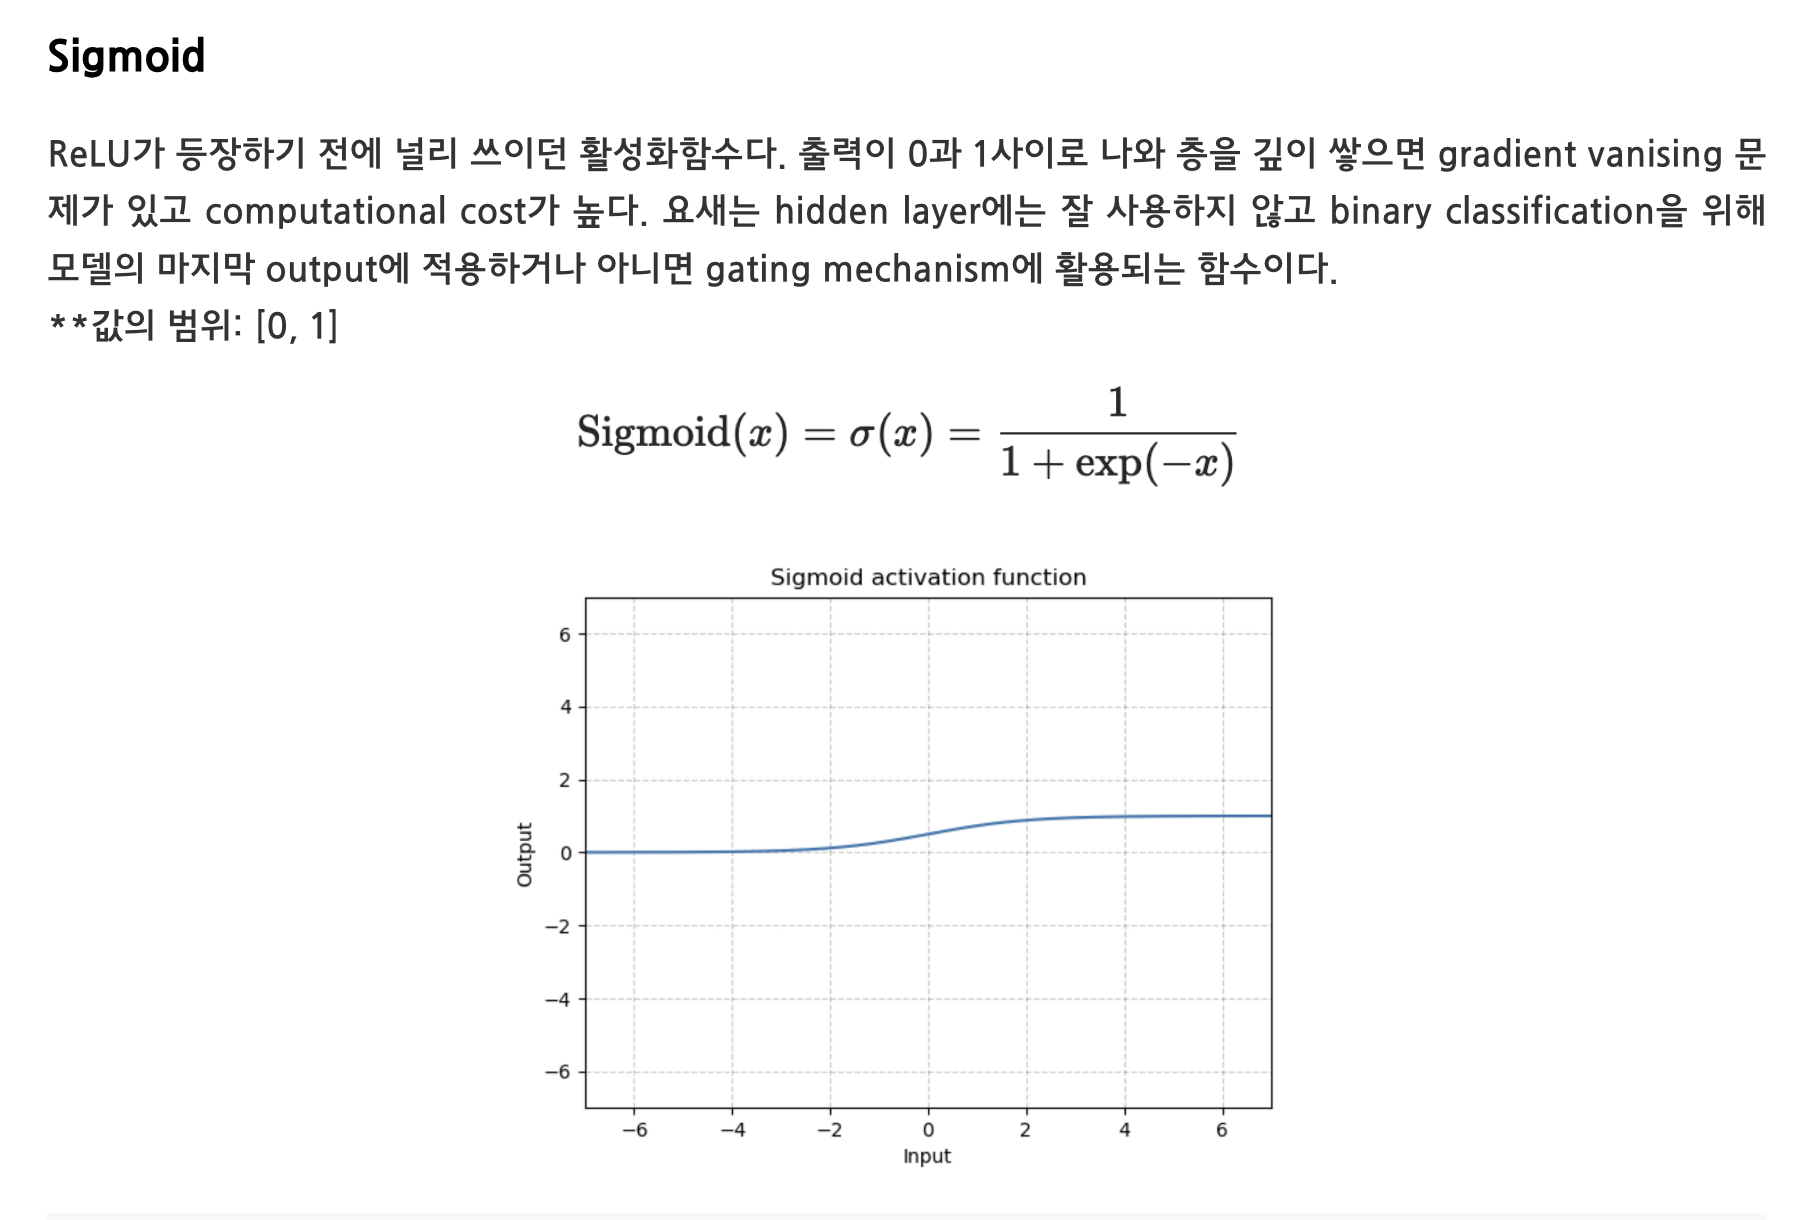

In [1]:
from sklearn.datasets import load_wine

data = load_wine()
# 데이터셋 종류 :
#data = load_breast_cancer()

In [2]:
input = data.data
output = data.target

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' #GPU가 가능하면 GPU에 업로드

torch.manual_seed(777)
if device == "cuda":
  torch.cuda.manual_seed_all(777)

In [8]:
x_train, x_test, y_train, y_test = train_test_split(input, output, test_size = 0.3, random_state = 42, stratify= data.target, shuffle = True)
# stratify: target 값으로 지정해서 target class 비율을 유지한 채 데이터셋을 나눔

x_train = torch.FloatTensor(x_train).to(device) # FloatTensor: 32-bit floating-point
y_train = torch.LongTensor(y_train).to(device) # LongTensor: 64-bit integer
x_test = torch.FloatTensor(x_test)
y_test = torch.LongTensor(y_test)

# 데이터를 tensor로 바꿔주고 gpu 연산이 가능해지도록 gpu에 옮김
# label 값을 왜 long 에 옮겨놓는가? loss function이 다르기 때문

In [9]:
input

array([[1.423e+01, 1.710e+00, 2.430e+00, ..., 1.040e+00, 3.920e+00,
        1.065e+03],
       [1.320e+01, 1.780e+00, 2.140e+00, ..., 1.050e+00, 3.400e+00,
        1.050e+03],
       [1.316e+01, 2.360e+00, 2.670e+00, ..., 1.030e+00, 3.170e+00,
        1.185e+03],
       ...,
       [1.327e+01, 4.280e+00, 2.260e+00, ..., 5.900e-01, 1.560e+00,
        8.350e+02],
       [1.317e+01, 2.590e+00, 2.370e+00, ..., 6.000e-01, 1.620e+00,
        8.400e+02],
       [1.413e+01, 4.100e+00, 2.740e+00, ..., 6.100e-01, 1.600e+00,
        5.600e+02]])

In [10]:
print(x_train[0])
print(y_train[0])
# input 13개 (속성이 13개)
# y의 class는 3개
list(data.target_names)

tensor([1.3750e+01, 1.7300e+00, 2.4100e+00, 1.6000e+01, 8.9000e+01, 2.6000e+00,
        2.7600e+00, 2.9000e-01, 1.8100e+00, 5.6000e+00, 1.1500e+00, 2.9000e+00,
        1.3200e+03], device='cuda:0')
tensor(0, device='cuda:0')


['class_0', 'class_1', 'class_2']

파이토치에서는 데이터셋을 좀 더 쉽게 다룰 수 있도록 유용한 도구로서 torch.utils.data.Dataset과 torch.utils.data.DataLoader를 제공합니다. 이를 사용하면 미니 배치 학습, 데이터 셔플(shuffle), 병렬 처리까지 간단히 수행할 수 있습니다. 기본적인 사용 방법은 Dataset을 정의하고, 이를 DataLoader에 전달하는 것
- init : class 에서 객체가 생성되면 바로 실행되는 함수
- len : observation 수를 정의하는 함수
- getitem : iteration 마다 해당하는 데이터를 돌려주는 함수

In [11]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
  def __init__(self):
    self.x_data = x_train
    self.y_data = [[y] for y in y_train]
#  데이터셋의 전처리를 해주는 부분

  def __len__(self):
    return len(self.x_data)
#  데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분

  def __getitem__(self, idx):
    x = torch.FloatTensor(self.x_data[idx]).to(device)
    y = torch.LongTensor(self.y_data[idx]).to(device)
#  데이터셋에서 특정 1개의 샘플을 가져오는 함수

    return x,y

In [12]:
batch_size = 8

dataset = CustomDataset()
dataloader = DataLoader(dataset, batch_size=batch_size)

In [13]:
model = nn.Sequential(
          nn.Linear(13,213, bias=True), #input 속성이 13개
          nn.Sigmoid(),
          nn.Linear(213,32, bias=True),
          nn.Sigmoid(),
          nn.Linear(32,10, bias=True),
          nn.Sigmoid(),
          nn.Linear(10,3, bias=True), #output 클래스는 3개
          nn.Softmax() # dimension = 1, 행(sample)별로 계산 -> 일반적으로 분류 / default: dimension = none 마지막 텐서 / 0, 열(feature)별로 계산
          ).to(device)

class로 구현 가능
- init : 초기 생성 함수
- foward : 순전파(입력값 => 예측값 의 과정)

In [14]:
class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(13,213, bias=True), # input_layer = 13, hidden_layer1 = 213 -> 어떤 수가 최적일까
          nn.Sigmoid(),
        nn.BatchNorm1d(213)
    )
  # activation function 이용
  #   nn.ReLU()
  #   nn.tanH()
  #   https://pytorch.org/docs/stable/nn.html 그 외에도 여기서 확인 가능함
  #   파라미터가 필요하지 않다는 것이 특징

  # batch normazliation 1d, 파라미터 값으로 vector의 길이를 전해줌
  # 추후에 이미지를 다루게 된다면, 그때는 batch normalization 2d를 이용하게 됨
  # 그때는 파라미터 값으로 채널, 가로, 세로 길이를 전달해주게 됨

    self.layer2 = nn.Sequential(
          nn.Linear(213,32, bias=True), # hidden_layer1 = 213, hidden_layer2 = 32
        nn.Sigmoid()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(32,10, bias=True), # hidden_layer2 = 32, hidden_layer3 = 10
        nn.Sigmoid()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(10, 3, bias=True), # hidden_layer3 = 10, output_layer = 3
        nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

In [15]:
def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

        # xavier사용
        # Layer의 weight를 어떤 분포를 가지도록 초기화시켜줌+global minimum찾기 위해서
        # import torch.nn.init as init 로 모듈을 먼저 불러오기도

In [16]:
model = Model().to(device)
model.apply(init_weights)

<ipython-input-15-33764106f641>:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)


Model(
  (layer1): Sequential(
    (0): Linear(in_features=13, out_features=213, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(213, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=213, out_features=32, bias=True)
    (1): Sigmoid()
  )
  (layer3): Sequential(
    (0): Linear(in_features=32, out_features=10, bias=True)
    (1): Sigmoid()
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=3, bias=True)
    (1): Softmax(dim=None)
  )
)

In [17]:
print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=13, out_features=213, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(213, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=213, out_features=32, bias=True)
    (1): Sigmoid()
  )
  (layer3): Sequential(
    (0): Linear(in_features=32, out_features=10, bias=True)
    (1): Sigmoid()
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=3, bias=True)
    (1): Softmax(dim=None)
  )
)


In [18]:
loss_fn  = nn.CrossEntropyLoss().to(device)

# 여러가지 optimizer 시도해보기
# lr 바꿔보기

optimizer = optim.Adam(model.parameters(), lr= 0.01)

# https://pytorch.org/docs/stable/optim.html#module-torch.optim 페이지 참조
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# sgd 등등

In [19]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


0 1.109588384628296
10 0.949062168598175
20 0.8707650303840637
30 0.8127037882804871
40 0.7222650051116943
50 0.6537120342254639
60 0.6438564658164978
70 0.6005004644393921
80 0.5916985869407654
90 0.5807543396949768


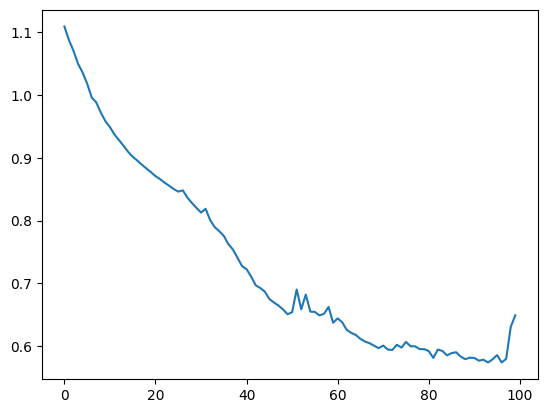

In [20]:
plt.plot(losses)
plt.show()

In [21]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

In [22]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [0.99148977 0.00349057 0.00501973]
argmax를 한 후의 output은 0
accuracy는 0.8333333333333334


# 1.2.1 Load_wine
### activation function: ```reLU ```
### Optimizer: ```adam```,
### lr: 0.01

model의 output은 :  [9.9999821e-01 5.8700961e-11 1.8138147e-06]
argmax를 한 후의 output은 0
***accuracy는 0.9259259259259259(활성화 함수 중 최고)***

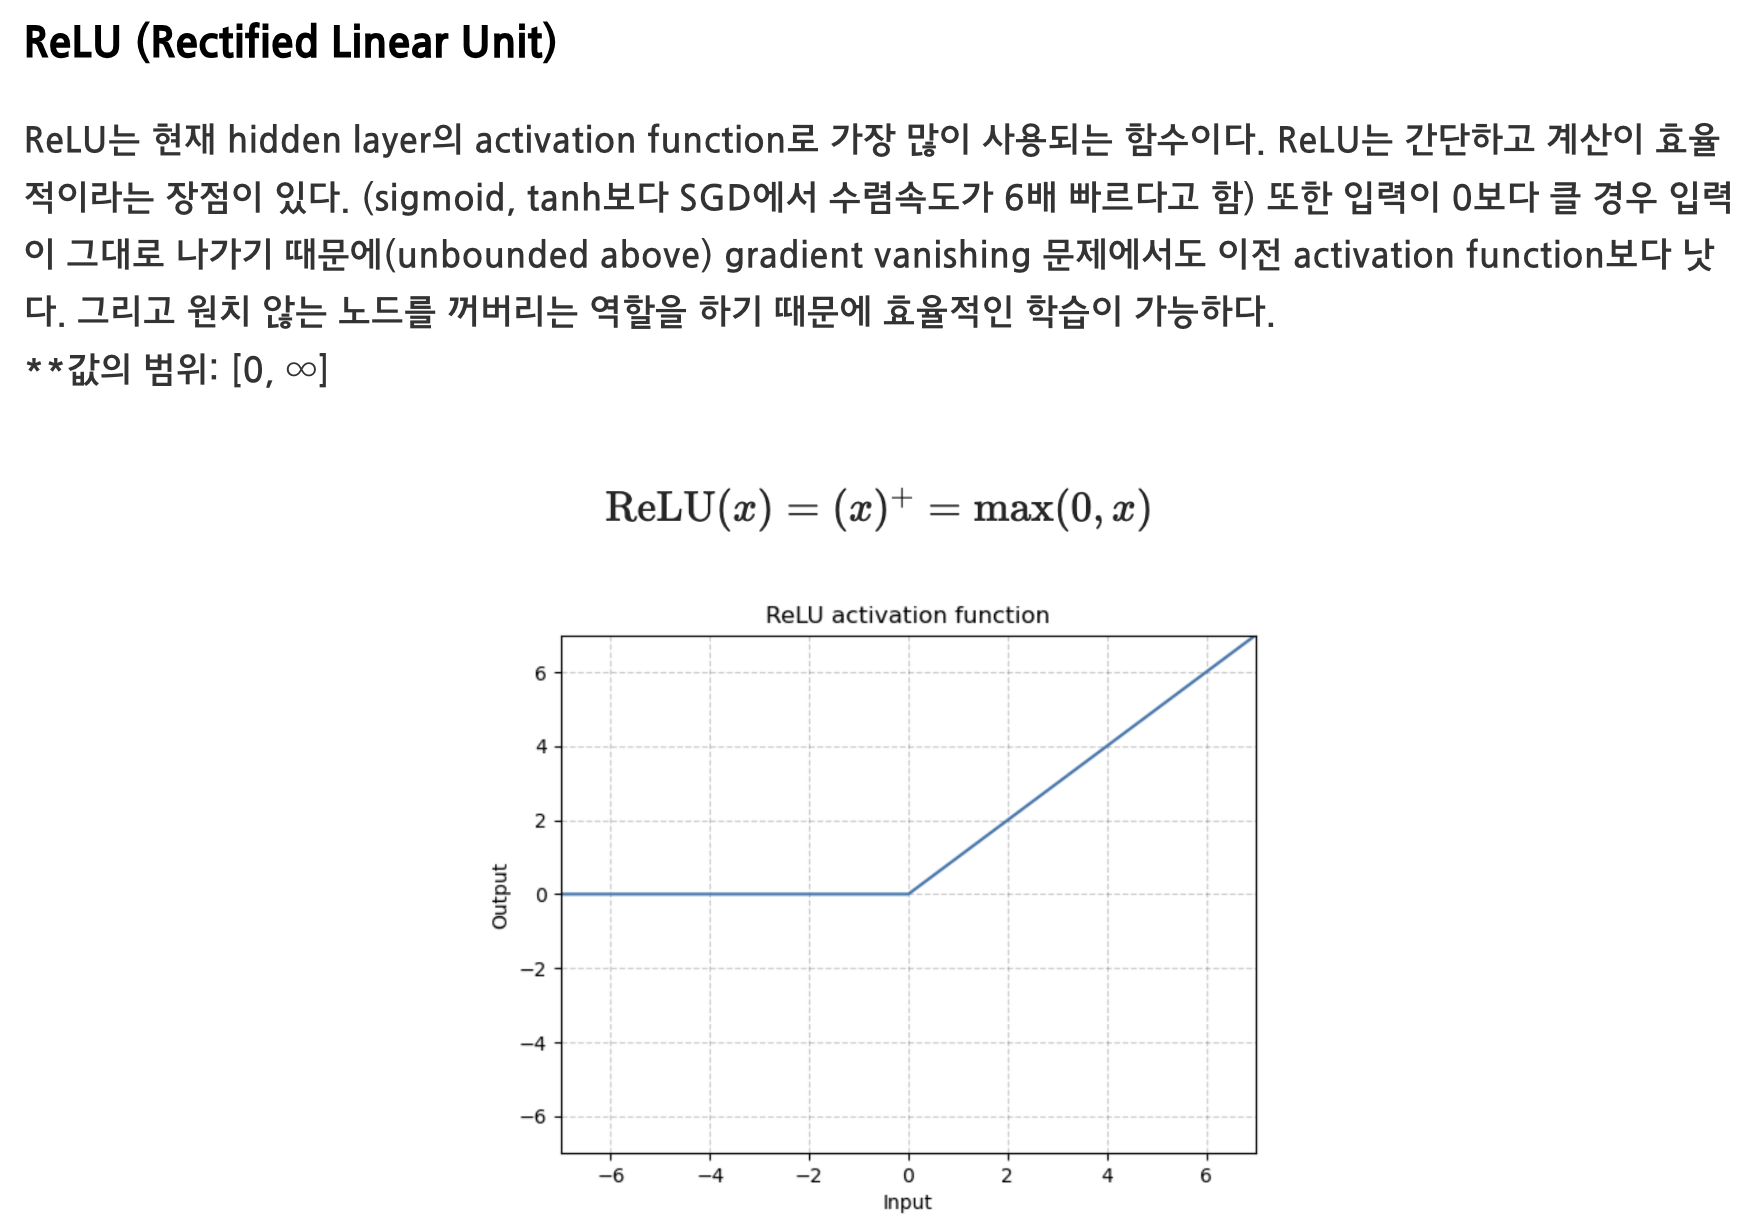

In [23]:
class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(13,213, bias=True), # input_layer = 13, hidden_layer1 = 213 -> 어떤 수가 최적일까
          nn.ReLU(),
        nn.BatchNorm1d(213)
    )
    self.layer2 = nn.Sequential(
          nn.Linear(213,32, bias=True), # hidden_layer1 = 213, hidden_layer2 = 32
        nn.ReLU()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(32,10, bias=True), # hidden_layer2 = 32, hidden_layer3 = 10
        nn.ReLU()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(10, 3, bias=True), # hidden_layer3 = 10, output_layer = 3
        nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

In [24]:
def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

In [25]:
model = Model().to(device)
model.apply(init_weights)

<ipython-input-24-6dcf2c5a1d5c>:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)


Model(
  (layer1): Sequential(
    (0): Linear(in_features=13, out_features=213, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(213, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=213, out_features=32, bias=True)
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=32, out_features=10, bias=True)
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=3, bias=True)
    (1): Softmax(dim=None)
  )
)

In [26]:
loss_fn  = nn.CrossEntropyLoss().to(device)

optimizer = optim.Adam(model.parameters(), lr= 0.01)

In [27]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


0 1.0081623792648315
10 0.7423608899116516
20 0.6336838006973267
30 0.6024340391159058
40 0.5981121063232422
50 0.5910658836364746
60 0.5829037427902222
70 0.5816807150840759
80 0.5752645134925842
90 0.5750989317893982


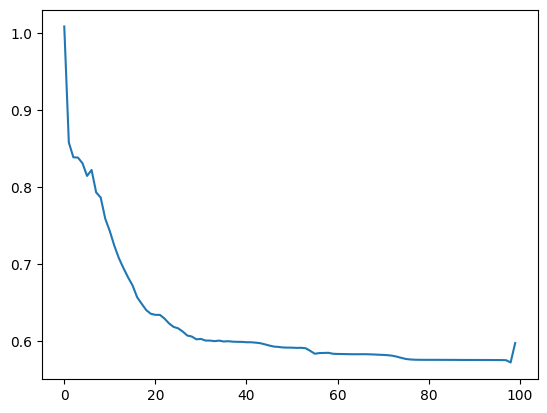

In [28]:
plt.plot(losses)
plt.show()

In [29]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

In [30]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [9.9999821e-01 5.8700961e-11 1.8138147e-06]
argmax를 한 후의 output은 0
accuracy는 0.9259259259259259


# 1.2.2 Load_wine
### activation function: ```reLU ```
### Optimizer: ```sgd```,
### lr: 0.01

model의 output은 :  [9.9999797e-01 7.8278424e-09 2.0149812e-06]
argmax를 한 후의 output은 0
**accuracy는 0.6481481481481481**

In [42]:
class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(13,213, bias=True), # input_layer = 13, hidden_layer1 = 213 -> 어떤 수가 최적일까
          nn.ReLU(),
        nn.BatchNorm1d(213)
    )
    self.layer2 = nn.Sequential(
          nn.Linear(213,32, bias=True), # hidden_layer1 = 213, hidden_layer2 = 32
        nn.ReLU()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(32,10, bias=True), # hidden_layer2 = 32, hidden_layer3 = 10
        nn.ReLU()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(10, 3, bias=True), # hidden_layer3 = 10, output_layer = 3
        nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

In [43]:
def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

In [44]:
model = Model().to(device)
model.apply(init_weights)

<ipython-input-43-6dcf2c5a1d5c>:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)


Model(
  (layer1): Sequential(
    (0): Linear(in_features=13, out_features=213, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(213, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=213, out_features=32, bias=True)
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=32, out_features=10, bias=True)
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=3, bias=True)
    (1): Softmax(dim=None)
  )
)

In [45]:
loss_fn  = nn.CrossEntropyLoss().to(device)

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# sgd에다가 이전의 이동값을 고려하도록 설계하여 momentum. 즉 관성을 준다. 혹여 local min에 도달하더라도 앞으로 나아가서 local min을 탈출할 수 있도록 설정해준다.
# momentum값은 0.9에서 시작하며, 0.95, 0.99로 증가시키며 사용! ** default는 0

In [46]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

0 1.1210331916809082
10 0.8412902355194092
20 0.8282655477523804
30 0.8113690614700317
40 0.7935861945152283
50 0.7889648675918579
60 0.7611711025238037
70 0.7659488320350647
80 0.767164945602417
90 0.7953329682350159


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


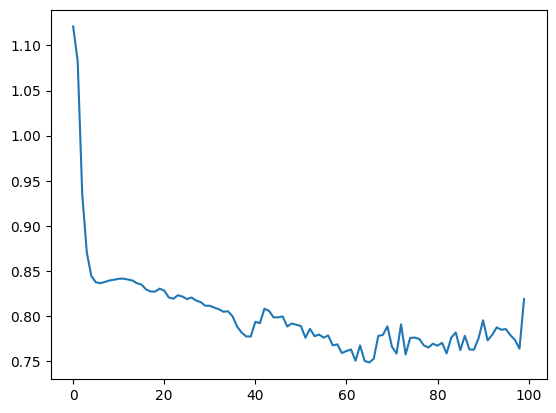

In [47]:
plt.plot(losses)
plt.show()

In [48]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

In [49]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [9.9999797e-01 7.8278424e-09 2.0149812e-06]
argmax를 한 후의 output은 0
accuracy는 0.6481481481481481


# 1.2.3 Load_wine(Best Accuracy)
### activation function: ```reLU ```
### Optimizer: ```adam```,
### lr: 0.005

model의 output은 :  [9.999981e-01 1.891155e-06 3.106505e-09]
argmax를 한 후의 output은 0
***🥇accuracy는 0.9629629629629629🥇***

In [58]:
class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(13,213, bias=True), # input_layer = 13, hidden_layer1 = 213 -> 어떤 수가 최적일까
          nn.ReLU(),
        nn.BatchNorm1d(213)
    )
    self.layer2 = nn.Sequential(
          nn.Linear(213,32, bias=True), # hidden_layer1 = 213, hidden_layer2 = 32
        nn.ReLU()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(32,10, bias=True), # hidden_layer2 = 32, hidden_layer3 = 10
        nn.ReLU()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(10, 3, bias=True), # hidden_layer3 = 10, output_layer = 3
        nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

In [59]:
def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

In [60]:
model = Model().to(device)
model.apply(init_weights)

<ipython-input-59-6dcf2c5a1d5c>:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)


Model(
  (layer1): Sequential(
    (0): Linear(in_features=13, out_features=213, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(213, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=213, out_features=32, bias=True)
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=32, out_features=10, bias=True)
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=3, bias=True)
    (1): Softmax(dim=None)
  )
)

In [61]:
loss_fn  = nn.CrossEntropyLoss().to(device)

optimizer = optim.Adam(model.parameters(), lr= 0.005)

In [62]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

0 1.1206010580062866
10 0.7287671566009521
20 0.6256992816925049
30 0.5995254516601562
40 0.5874199867248535
50 0.5819535255432129
60 0.576002299785614
70 0.5656735897064209
80 0.5539038777351379
90 0.5519042015075684


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


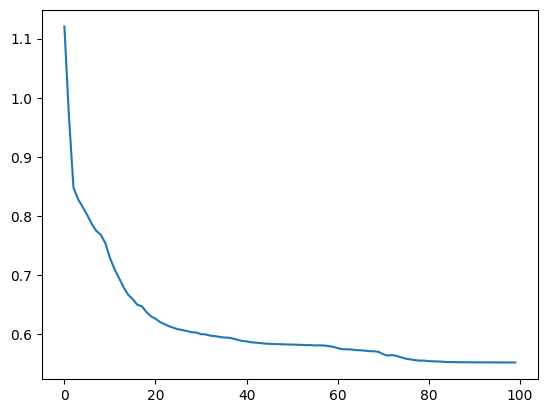

In [63]:
plt.plot(losses)
plt.show()

In [64]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

In [65]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [9.999981e-01 1.891155e-06 3.106505e-09]
argmax를 한 후의 output은 0
accuracy는 0.9629629629629629


# 1.2.4 Load_wine
### activation function: ```reLU ```
### Optimizer: ```adam```,
### lr: 0.001

model의 output은 :  [9.9798346e-01 5.6963792e-04 1.4468451e-03]
argmax를 한 후의 output은 0
**accuracy는 0.9444444444444444**

In [66]:
class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(13,213, bias=True), # input_layer = 13, hidden_layer1 = 213 -> 어떤 수가 최적일까
          nn.ReLU(),
        nn.BatchNorm1d(213)
    )
    self.layer2 = nn.Sequential(
          nn.Linear(213,32, bias=True), # hidden_layer1 = 213, hidden_layer2 = 32
        nn.ReLU()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(32,10, bias=True), # hidden_layer2 = 32, hidden_layer3 = 10
        nn.ReLU()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(10, 3, bias=True), # hidden_layer3 = 10, output_layer = 3
        nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

In [67]:
def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

In [68]:
model = Model().to(device)
model.apply(init_weights)

<ipython-input-67-6dcf2c5a1d5c>:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)


Model(
  (layer1): Sequential(
    (0): Linear(in_features=13, out_features=213, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(213, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=213, out_features=32, bias=True)
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=32, out_features=10, bias=True)
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=3, bias=True)
    (1): Softmax(dim=None)
  )
)

In [69]:
loss_fn  = nn.CrossEntropyLoss().to(device)

optimizer = optim.Adam(model.parameters(), lr= 0.001)

In [70]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

0 1.1086326837539673
10 0.8736345767974854
20 0.8231661915779114
30 0.7939985990524292
40 0.7680807709693909
50 0.7268308997154236
60 0.6782670021057129
70 0.6393131613731384
80 0.6138721108436584
90 0.6011010408401489


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


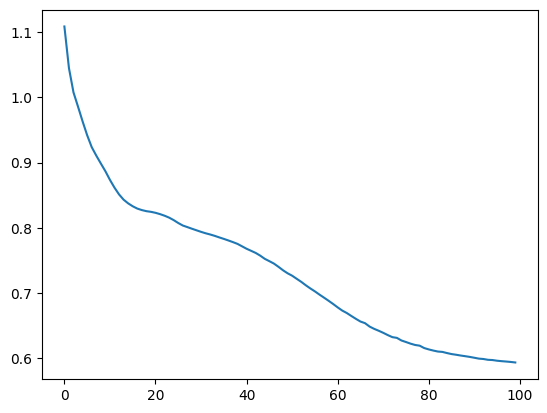

In [71]:
plt.plot(losses)
plt.show()

In [72]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

In [73]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [9.9798346e-01 5.6963792e-04 1.4468451e-03]
argmax를 한 후의 output은 0
accuracy는 0.9444444444444444


# 1.2.5 Load_wine
### activation function: ```reLU ```
### Optimizer: ```adam```,
### lr: 0.005
### one less layer

model의 output은 :  [9.9998569e-01 8.5055772e-06 5.7836182e-06]
argmax를 한 후의 output은 0
**accuracy는 0.9629629629629629(
  layer 하나 줄이니까 output 값은 다르지만 accuracy 동일)**

In [82]:
class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(13,213, bias=True), # input_layer = 13, hidden_layer1 = 213 -> 어떤 수가 최적일까
          nn.ReLU(),
        nn.BatchNorm1d(213)
    )
    self.layer2 = nn.Sequential(
          nn.Linear(213,50, bias=True), # hidden_layer1 = 213, hidden_layer2 = 32
        nn.ReLU()
    )
    self.layer3 = nn.Sequential(
        nn.Linear(50, 3, bias=True), # hidden_layer3 = 32, output_layer = 3
        nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    return output

In [83]:
def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

In [84]:
model = Model().to(device)
model.apply(init_weights)

<ipython-input-83-6dcf2c5a1d5c>:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)


Model(
  (layer1): Sequential(
    (0): Linear(in_features=13, out_features=213, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(213, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=213, out_features=50, bias=True)
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=50, out_features=3, bias=True)
    (1): Softmax(dim=None)
  )
)

In [85]:
loss_fn  = nn.CrossEntropyLoss().to(device)

optimizer = optim.Adam(model.parameters(), lr= 0.005)

In [86]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

0 1.184717059135437
10 0.8109003901481628
20 0.6626495122909546
30 0.6063769459724426
40 0.5944021940231323
50 0.5889822840690613
60 0.5723241567611694
70 0.5608019828796387
80 0.5544771552085876
90 0.5525878667831421


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


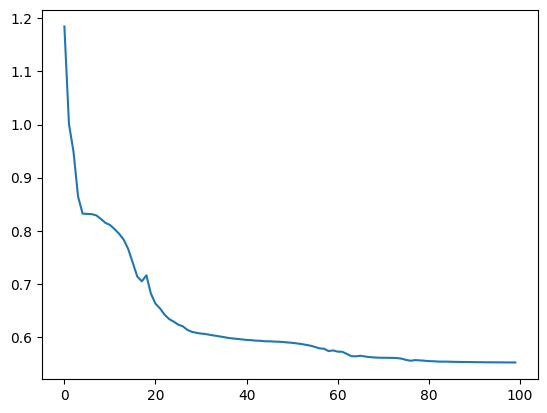

In [87]:
plt.plot(losses)
plt.show()

In [88]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

In [89]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [9.9998569e-01 8.5055772e-06 5.7836182e-06]
argmax를 한 후의 output은 0
accuracy는 0.9629629629629629


# 1.3 Load_wine
### activation function: ```Tanh```
### Optimizer: ```adam```,
### lr: 0.01

model의 output은 :  [9.9362296e-01 4.4325487e-05 6.3327332e-03]
argmax를 한 후의 output은 0
**accuracy는 0.7592592592592593**

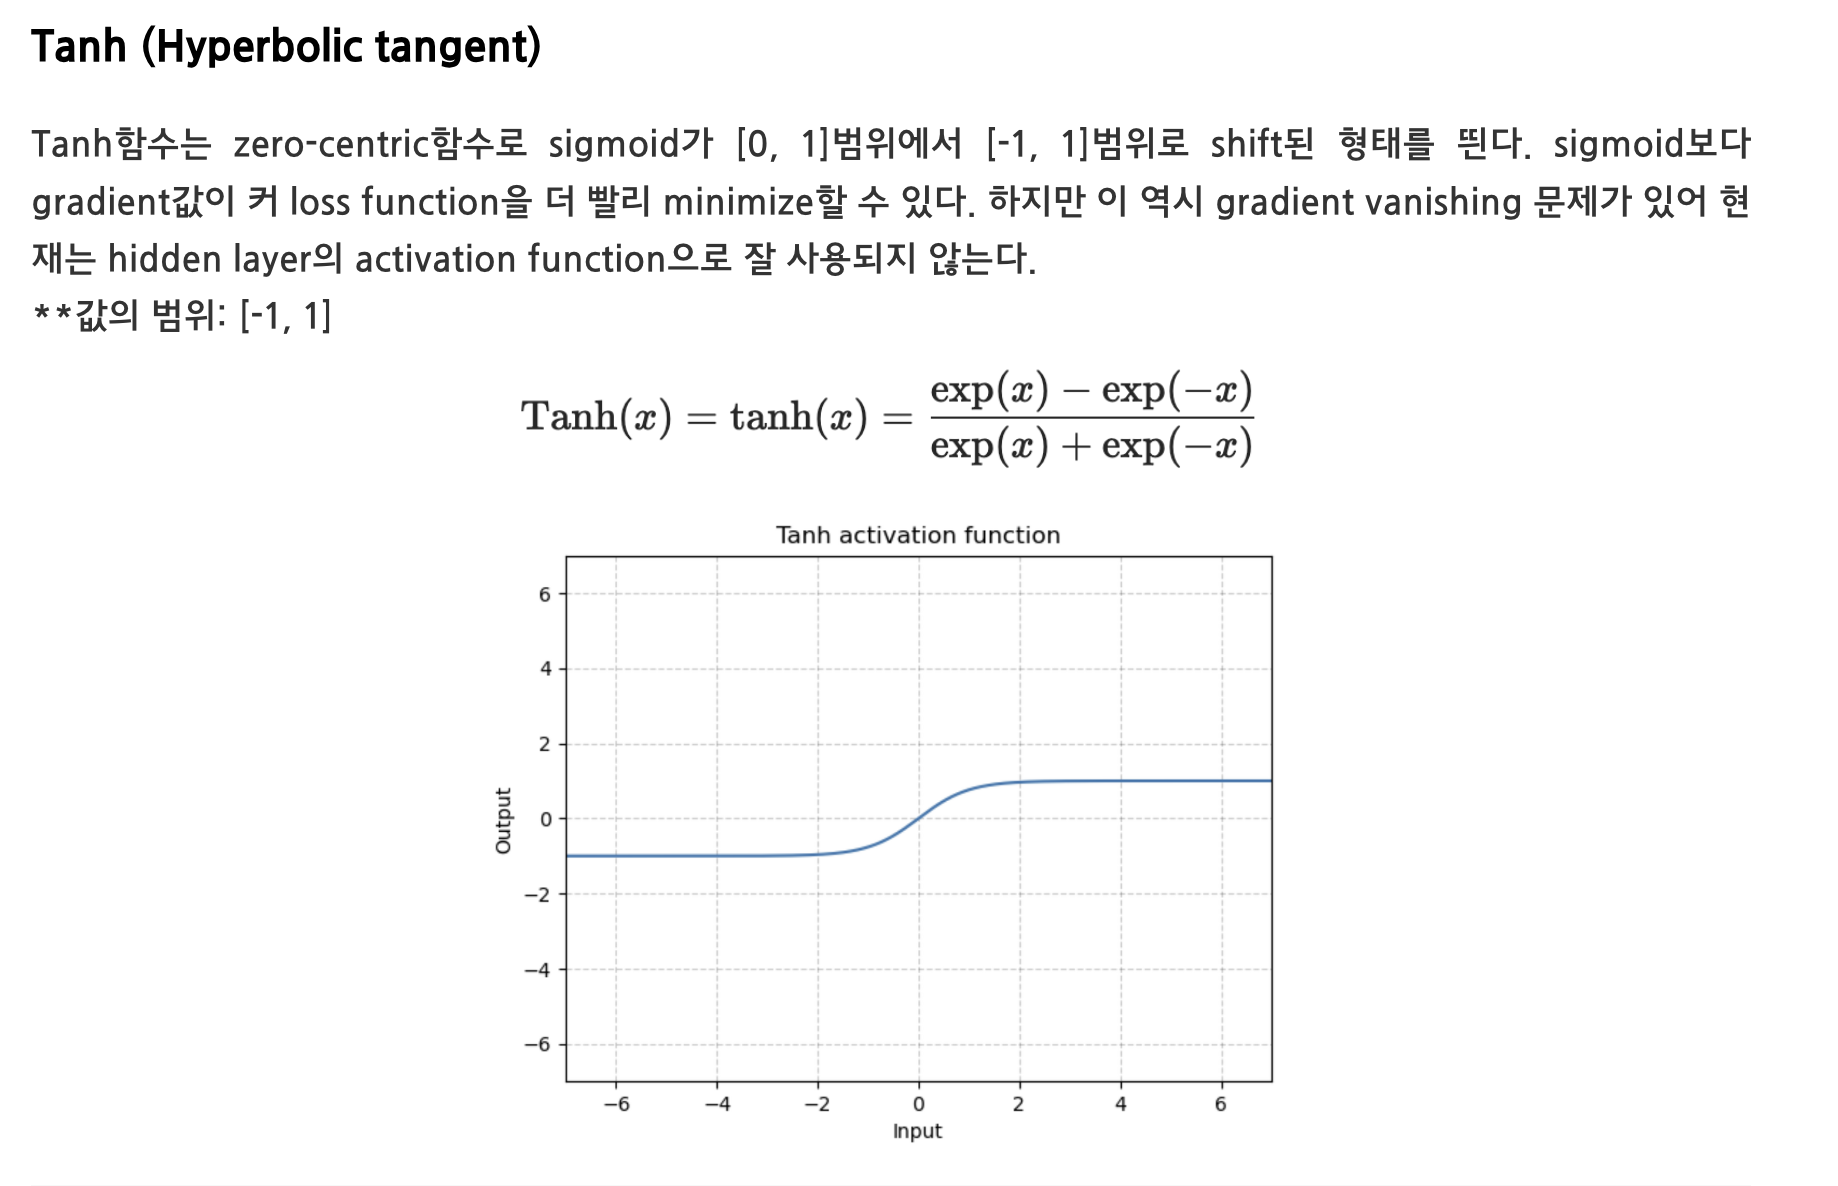

In [34]:
class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(13,213, bias=True), # input_layer = 13, hidden_layer1 = 213 -> 어떤 수가 최적일까
          nn.Tanh(),
        nn.BatchNorm1d(213)
    )
    self.layer2 = nn.Sequential(
          nn.Linear(213,32, bias=True), # hidden_layer1 = 213, hidden_layer2 = 32
        nn.Tanh()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(32,10, bias=True), # hidden_layer2 = 32, hidden_layer3 = 10
        nn.Tanh()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(10, 3, bias=True), # hidden_layer3 = 10, output_layer = 3
        nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

In [35]:
def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

In [36]:
model = Model().to(device)
model.apply(init_weights)

<ipython-input-35-6dcf2c5a1d5c>:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)


Model(
  (layer1): Sequential(
    (0): Linear(in_features=13, out_features=213, bias=True)
    (1): Tanh()
    (2): BatchNorm1d(213, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=213, out_features=32, bias=True)
    (1): Tanh()
  )
  (layer3): Sequential(
    (0): Linear(in_features=32, out_features=10, bias=True)
    (1): Tanh()
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=3, bias=True)
    (1): Softmax(dim=None)
  )
)

In [37]:
loss_fn  = nn.CrossEntropyLoss().to(device)

optimizer = optim.Adam(model.parameters(), lr= 0.01)

In [38]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

0 1.1688932180404663
10 0.8457913994789124
20 0.7836636900901794
30 0.712549090385437
40 0.6304113268852234
50 0.6305526494979858
60 0.6238176226615906
70 0.6204167604446411
80 0.6221071481704712
90 0.6213273406028748


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


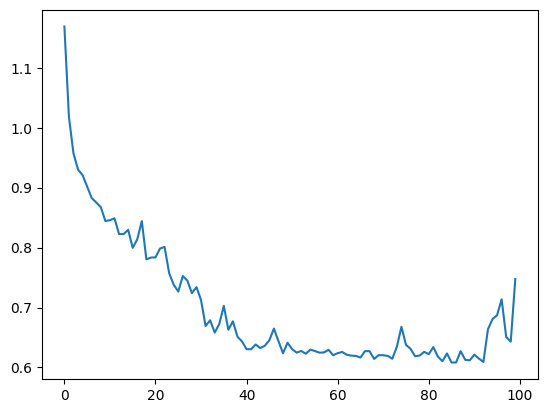

In [39]:
plt.plot(losses)
plt.show()

In [40]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

In [41]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [9.9362296e-01 4.4325487e-05 6.3327332e-03]
argmax를 한 후의 output은 0
accuracy는 0.7592592592592593


# < 3주차 과제 2 : CNN 맛보기>



In [90]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

# argparse: 프로그램이 필요한 인자를 정의하면, argparse 는 sys.argv 를 어떻게 파싱할지 파악한다. 또한 argparse 모듈은 도움말과 사용법 메시지를 자동 생성하고, 사용자가 프로그램에 잘못된 인자를 줄 때 에러를 발생시킨다

In [91]:
# Training settings

batch_size = 64

# MNIST Dataset
train_dataset = datasets.MNIST(root='./data/',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='./data/',
                              train=False,
                              transform=transforms.ToTensor())

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 82870326.34it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 36257316.32it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 20306932.53it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6633192.47it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [92]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 10, kernel_size = 5)
    self.conv2 = nn.Conv2d(10, 20, kernel_size = 5) # 이전 output layer와 이후 input layer 같게
    self.mp = nn.MaxPool2d(2) # maximum pooling: calculating the maximum value of the elements in the pooling window
    self.fc = nn.Linear(320 , 10) ### : RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x320<- and 300x10)
# fully connected layer with input size(320) and output size(10)

  def forward(self, x):
    in_size = x.size(0)
    x = F.relu(self.mp(self.conv1(x))) # (28-4)/2 = 12
    x = F.relu(self.mp(self.conv2(x))) # (12-4)/2 = 4
    x = x.view(in_size, -1) # flatten the tensor # 4 * 4 * 20 = 320
    x = self.fc(x)
    return F.log_softmax(x)

In [93]:
model = Net()
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)

In [94]:
def train(epoch):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = Variable(data), Variable(target)
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    ## torch.nn.functional.nll_loss: cross-entrophy 손실함수
    ## torch.nn.functional.nll_loss(input, target, weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean')
    ## NLLLoss만 적용한 모델은 모델 마지막 레이어에 Softmax가 있음 <-> CrossEntropyLoss 안에는 LogSoftmax+NLLLoss가 함께 사용
    loss.backward()
    optimizer.step()
    if batch_idx % 10 == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))

In [95]:
def test():
    model.eval()  # model.eval(): 모델을 평가 모드로 전환하는 메서드
                  # 드롭아웃이 비활성화되고 배치 정규화의 이동 평균과 이동 분산이 업데이트되지 않음
                  # 주로 테스트 데이터나 검증 데이터를 사용하여 모델을 평가할 때 사용. 평가 모드에서는 모델이 추론 시에 동일한 동작을 수행하도록 설정되어 있어, 모델의 성능 평가에 불필요한 노이즈를 줄이고 일관된 결과를 얻을 수 있다
                  # 모델을 학습(training)하는 동안 사용한 모델 객체를 추론(inference)할 때 model.eval()을 호출하여 추론 모드로 전환하고, 추론이 끝난 후에는 다시 model.train()을 호출하여 학습 모드로 전환하는 게 일반적
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data # nll_loss?? / cross entropy loss와의 관계 확인!
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [96]:
for epoch in range(1, 10):
    train(epoch)
    test()

<ipython-input-92-c5bb30d7a25f>:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.298560
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.305966
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.287377
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.269854
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.267215
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.258240
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.245630
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.227109
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.197367
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.152327
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.116389
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.929139
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.841930
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.722983
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.312610
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.259503
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.253619
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.900110
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.813843
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.756022
Train Epoch: 1 [12800/60000 (

<ipython-input-95-575113da3938>:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)
/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.1794, Accuracy: 9480/10000 (95%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.142421
Train Epoch: 2 [640/60000 (1%)]	Loss: 0.216596
Train Epoch: 2 [1280/60000 (2%)]	Loss: 0.064347
Train Epoch: 2 [1920/60000 (3%)]	Loss: 0.195459
Train Epoch: 2 [2560/60000 (4%)]	Loss: 0.191720
Train Epoch: 2 [3200/60000 (5%)]	Loss: 0.255969
Train Epoch: 2 [3840/60000 (6%)]	Loss: 0.146505
Train Epoch: 2 [4480/60000 (7%)]	Loss: 0.124041
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.134168
Train Epoch: 2 [5760/60000 (10%)]	Loss: 0.274293
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.074709
Train Epoch: 2 [7040/60000 (12%)]	Loss: 0.305869
Train Epoch: 2 [7680/60000 (13%)]	Loss: 0.217962
Train Epoch: 2 [8320/60000 (14%)]	Loss: 0.161752
Train Epoch: 2 [8960/60000 (15%)]	Loss: 0.182464
Train Epoch: 2 [9600/60000 (16%)]	Loss: 0.216057
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.188984
Train Epoch: 2 [10880/60000 (18%)]	Loss: 0.252308
Train Epoch: 2 [11520/60000 (19%)]	Loss: 0.111742
Train Epoch: 2 [12